In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage.filters import convolve

/home/aramesh/anaconda3/envs/comp-photo/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# create continuous edge detection function
# idea is to just do a 0-1 binary masking for continuous edges

# To find continuous edges : 
# We use cv2.canny
# which follows
# 1) noise reduction 2) find intensity and angle of gradient 3) NMS of edges based on angles
# 4) hysterisis thresholding

def gradient(img) : 
    
    temp = img[:,:].copy()
    row = np.zeros((1,temp.shape[1]))
    col = np.zeros((temp.shape[0]+2,1))
    temp2 = np.vstack((row,np.vstack((temp, row))))
    temp2 = np.hstack((col,np.hstack((temp2, col))))
    img = temp2.copy() 
    
    img_x = np.diff(img,n=1,axis=1)
    img_y = np.diff(img,n=1,axis=0) 
    
    img_x = img_x[1:-1,:-1]
    img_y = img_y[:-1,1:-1]

    return img_x, img_y # vector field

# for gradient orientation
def gaussian_kernel(size=5, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)

    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    return (G, theta)

# load image
img = cv2.imread('./data/gradient-domain-processing/messi1.jpg')

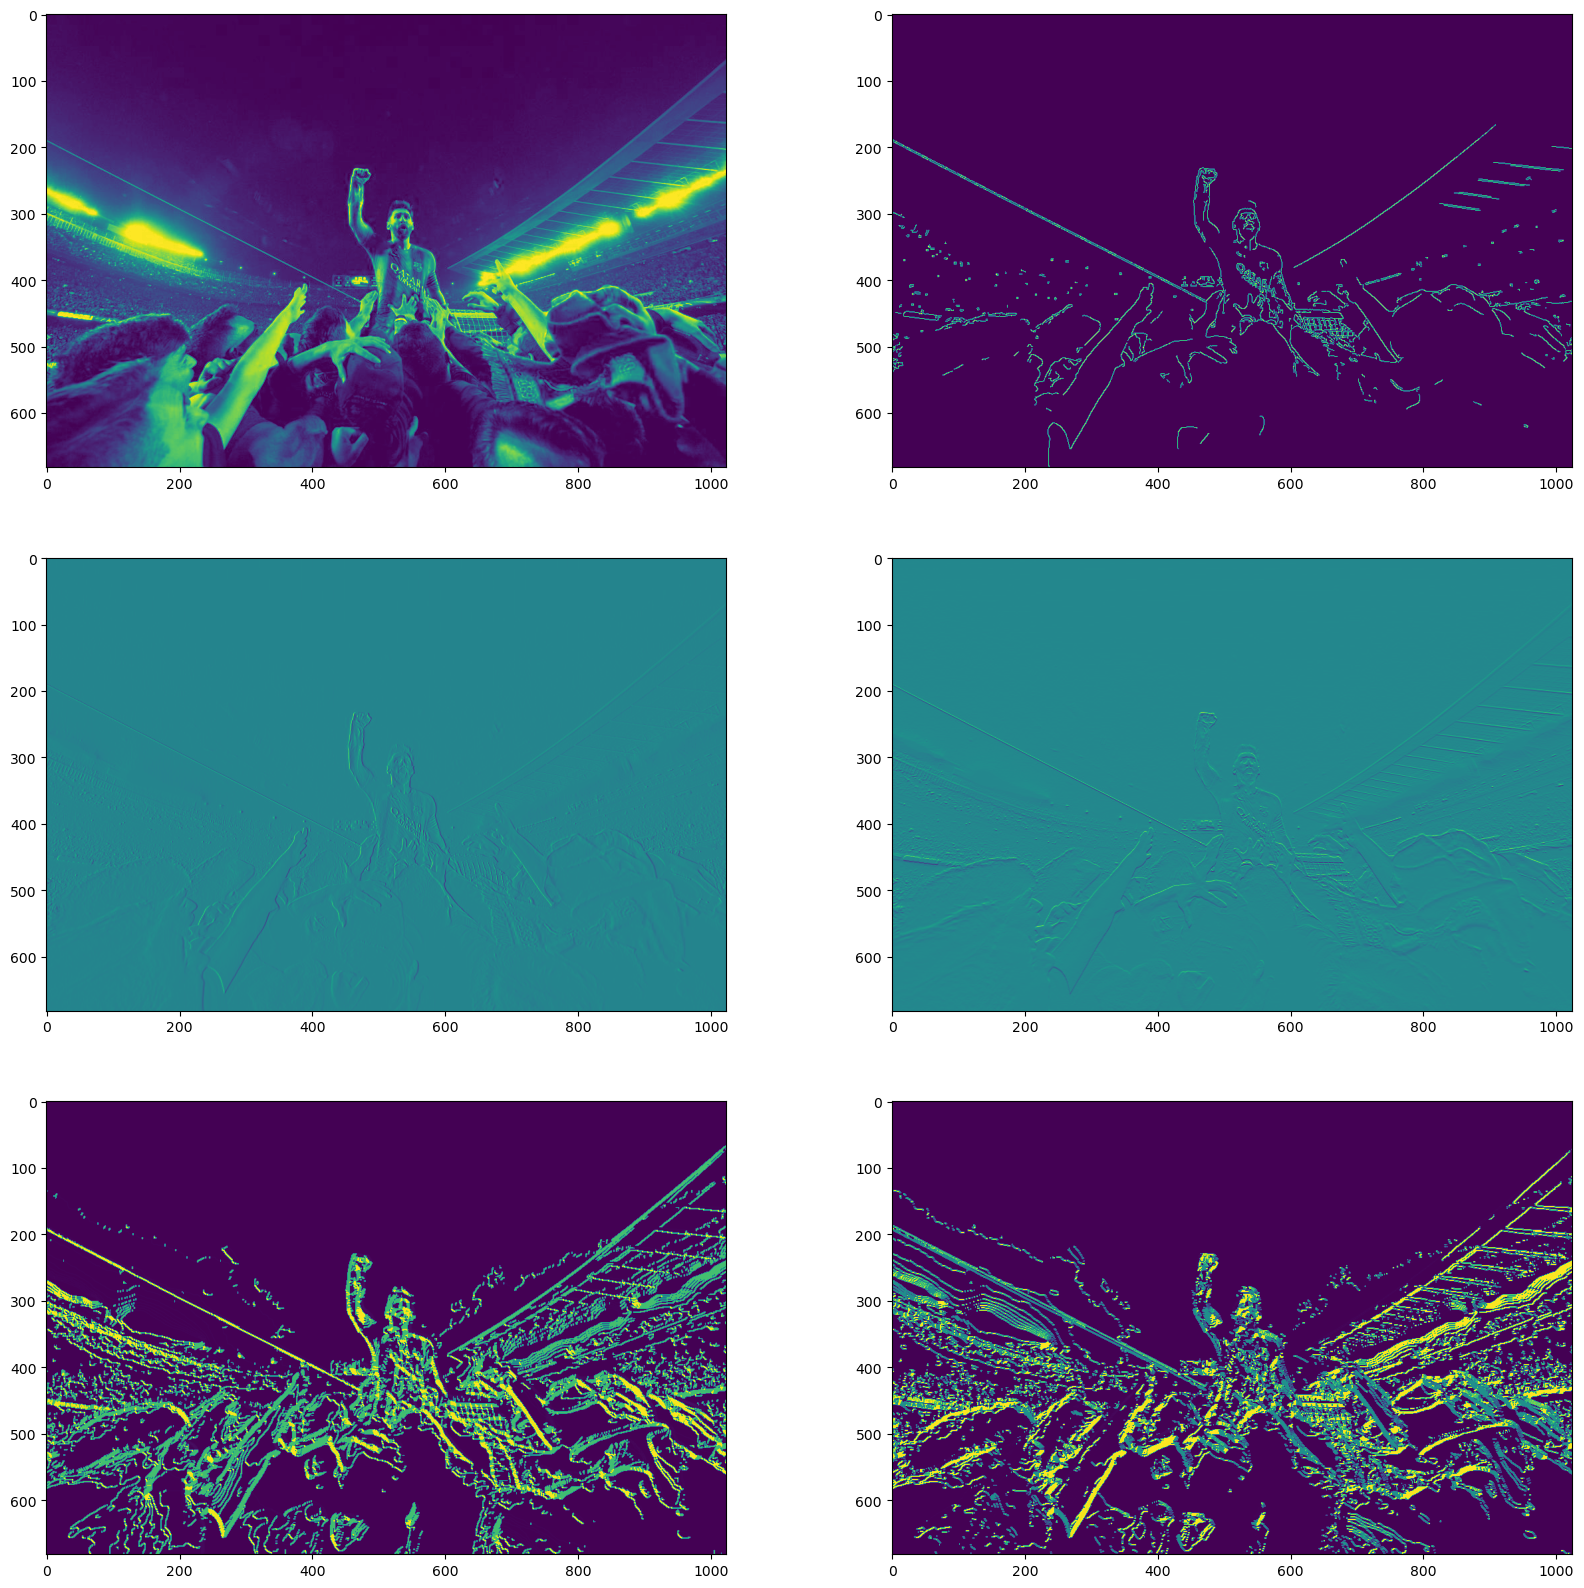

In [3]:
def get_required_features(img,for_display=False) : 
    u_x, u_y = gradient(img)

    canny_edges = cv2.Canny(img,300,500) # Messi
#     canny_edges = cv2.Canny(img,100,150) # dog
    img_smoothed = convolve(img, gaussian_kernel(5,10))
    gradientMat, thetaMat = sobel_filters(img_smoothed)
    
    if for_display : 
        return u_x, u_y, canny_edges, thetaMat, gradientMat
    return u_x, u_y, canny_edges, thetaMat

u_x, u_y, canny_edges, thetaMat, gradientMat = get_required_features(img[:,:,0],True)

fig, ax = plt.subplots(3,2, figsize=(20,20))
ax[0,0].imshow(img[:,:,0])
ax[0,1].imshow(canny_edges)
ax[1,0].imshow(u_x)
ax[1,1].imshow(u_y)
ax[2,0].imshow(gradientMat)
ax[2,1].imshow(thetaMat)
plt.show()

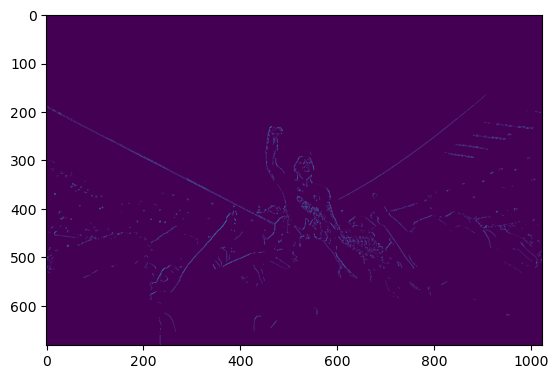

In [4]:
# So we have 
# img u
# gradients ux uy
# long/continuous edge orientation (thetaMat) and length(binary -> canny_edges)
# We need local gradient saliency

e_o = thetaMat.copy()
e_l = canny_edges.copy() / 255

def get_gradint_saliency(e_o, e_l, u_grad) : 
    s_grad = np.cos(e_o)**2 * e_l * u_grad
    return s_grad

s_x = get_gradint_saliency(e_o, e_l, u_x)
s_y = get_gradint_saliency(e_o, e_l, u_y)
plt.imshow(np.hypot(s_x,s_y))

# We also need the robust weighting function for derivatives
def robust_weighing(u_grad, g_grad,b=5) : 
    w_den = (np.abs(u_grad - g_grad) + 1)**b
    return 1.0 / w_den
#     return np.ones(u_grad.shape)


In [5]:
# from scipy.optimize import least_squares, fmin_cg, minimize, approx_fprime

# def energy_minimization(d,w_d,g_x,g_y,w_x,w_y) :
#     # this function uses lots of variables declared out of its own function scope
#     def get_energy(f) : 
#         e_d = w_d * (f-d_flat) **2
#         f_x, f_y = gradient(f.reshape(img.shape[0],img.shape[1]))
#         f_x, f_y = f_x.flatten(), f_y.flatten()
#         e_p = w_x_flat * (f_x - g_x_flat) ** 2 + w_y_flat * (f_y - g_y_flat) ** 2
#         return e_d + e_p
        
#     f_init = d.copy()
#     f_init = f_init.flatten()
#     d_flat = d.flatten()
#     g_x_flat = g_x.flatten()
#     g_y_flat = g_y.flatten()
#     w_x_flat = w_x.flatten()
#     w_y_flat = w_y.flatten()
      
#     ls_out = minimize(get_energy, f_init, method='Nelder-Mead')
# #     ls_out = fmin_cg(get_energy,f_init)
# #     ls_out = least_squares(get_energy,f_init,bounds=(0,255))

#     return ls_out

def energy_minimization_gradient_descent(d,w_d,g_x,g_y,w_x,w_y, lr=0.005, N=500, eps=0.0001) : 
    
    # img from global scope
    def get_energy(f,d_flat,w_d,g_x_flat,g_y_flat,w_x_flat,w_y_flat) : 
        e_d = w_d * (f-d_flat) **2
        f_x, f_y = gradient(f.reshape(img.shape[0],img.shape[1]))
        f_x, f_y = f_x.flatten(), f_y.flatten()
        e_p = w_x_flat * (f_x - g_x_flat) ** 2 + w_y_flat * (f_y - g_y_flat) ** 2
        energy = e_d + e_p
        energy = energy.reshape(img.shape[0],img.shape[1])
#         return energy
        return energy

    def derivative(func, x, h, *args):
#         print (func(x + h,*args) - func(x,*args))
        return (func(x + h,*args) - func(x,*args)) / h

    d_flat = d.flatten()
    f = d_flat.copy()
    g_x_flat = g_x.flatten()
    g_y_flat = g_y.flatten()
    w_x_flat = w_x.flatten()
    w_y_flat = w_y.flatten()
    
    for n in range(N) :
        
#         res = approx_fprime(f,get_energy,np.sqrt(np.finfo(float).eps),d_flat,w_d,g_x_flat,g_y_flat,w_x_flat,w_y_flat)
#         res = calc_gradient()
#         grad_x, grad_y = np.gradient(get_energy(f,d_flat,w_d,g_x_flat,g_y_flat,w_x_flat,w_y_flat))
#         res = grad_x + grad_y
        res = derivative(get_energy,f,1e-3,d_flat,w_d,g_x_flat,g_y_flat,w_x_flat,w_y_flat)
        f = f - lr * res.flatten()
        loss = np.sqrt(np.sum(res**2))
        if n%50 == 0 : print('iter : {}, loss : {}'.format(n,loss))
        if loss <= eps : break
            
    return f
        
    

iter : 0, loss : 0.16694130650436412
iter : 50, loss : 0.14368716996823339
iter : 100, loss : 0.12493778290894109
iter : 150, loss : 0.10918986655441285
iter : 200, loss : 0.09566767205425268
iter : 250, loss : 0.08392592181095261
iter : 300, loss : 0.07367429396668304
iter : 350, loss : 0.0647005003176997
iter : 400, loss : 0.05683615268915893
iter : 450, loss : 0.049941026798588355
iter : 0, loss : 0.06012300445701718
iter : 50, loss : 0.036928939376517936
iter : 100, loss : 0.022708762238797153
iter : 150, loss : 0.013989452686755461
iter : 200, loss : 0.00865096705785936
iter : 250, loss : 0.005398348618040004
iter : 300, loss : 0.0034423093961218694
iter : 350, loss : 0.0023021367564686774
iter : 400, loss : 0.0016783634475788284
iter : 450, loss : 0.0013692124911059472
iter : 0, loss : 0.0559629835505791
iter : 50, loss : 0.03425964633614541
iter : 100, loss : 0.020986776328417903
iter : 150, loss : 0.01286228381167678
iter : 200, loss : 0.007886428762428557
iter : 250, loss : 0.

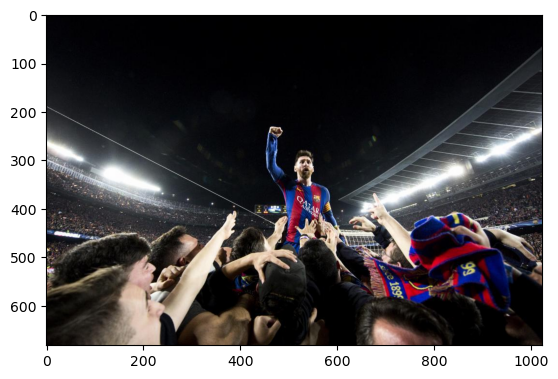

In [6]:
# We have all the tools needed for our applications

# 1) Saliency sharpen filter

def saliency_sharpen(u, c1=0.0001, c2=1) : 
    d = u.copy()
    w_d = c1
    u_x, u_y, e_l, e_o = get_required_features(u)
    s_x = get_gradint_saliency(e_o, e_l, u_x)
    s_y = get_gradint_saliency(e_o, e_l, u_y)
    g_x = u_x + c2 * s_x
    g_y = u_y + c2 * s_y
    w_x = robust_weighing(u_x, g_x)
    w_y = robust_weighing(u_y, g_y)
    
    ls_out = energy_minimization_gradient_descent(d,w_d,g_x,g_y,w_x,w_y)
    ls_out = ls_out.reshape((img.shape[0],img.shape[1]))
    
    return ls_out

salient_b = saliency_sharpen(img[:,:,0])
salient_g = saliency_sharpen(img[:,:,1])
salient_r = saliency_sharpen(img[:,:,2])

salient_rgb = np.array([salient_r,salient_g,salient_b])
salient_rgb = np.transpose(salient_rgb,(1,2,0))
plt.imshow(salient_rgb.astype('uint8'))

iter : 0, loss : 0.8533425214807383
iter : 50, loss : 0.8404561956143802
iter : 100, loss : 0.8278264652740922
iter : 150, loss : 0.8154177753625608
iter : 200, loss : 0.8032149995078647
iter : 250, loss : 0.7912106336510231
iter : 300, loss : 0.7794000357724157
iter : 350, loss : 0.76777965643766
iter : 400, loss : 0.7563463808266184
iter : 450, loss : 0.7450972837938266
iter : 0, loss : 1.3597446500247312
iter : 50, loss : 1.3392275243691971
iter : 100, loss : 1.3190755153419447
iter : 150, loss : 1.2992589870889866
iter : 200, loss : 1.279763866818878
iter : 250, loss : 1.2605819132129026
iter : 300, loss : 1.2417070990145291
iter : 350, loss : 1.2231342660206483
iter : 400, loss : 1.2048586245495874
iter : 450, loss : 1.1868755667303474
iter : 0, loss : 1.352762104620971
iter : 50, loss : 1.3323234776017174
iter : 100, loss : 1.3122486174907366
iter : 150, loss : 1.2925077834192307
iter : 200, loss : 1.2730868764657204
iter : 250, loss : 1.2539776584101083
iter : 300, loss : 1.2351

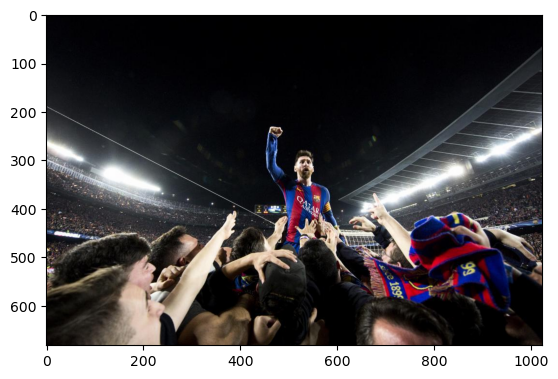

In [7]:
# 2) stylize filter

def stylize(u, c1=0.0001, c2=10, sigma=100) : 
    d = u.copy()
    w_d = c1
    u_x, u_y, e_l, e_o = get_required_features(u)
    e_l = e_l * 255
    n_p = c2 * (1 - np.exp((e_l**2)/(-2*sigma*sigma))) 
    g_x = u_x * (np.cos(e_o)**2) * n_p
    g_y = u_y * (np.sin(e_o)**2) * n_p
    w_x = robust_weighing(u_x, g_x)
    w_y = robust_weighing(u_y, g_y)
    
    ls_out = energy_minimization_gradient_descent(d,w_d,g_x,g_y,w_x,w_y)
    ls_out = ls_out.reshape((img.shape[0],img.shape[1]))
    
    return ls_out

stylize_b = stylize(img[:,:,0])
stylize_g = stylize(img[:,:,1])
stylize_r = stylize(img[:,:,2])

stylize_rgb = np.array([stylize_r,stylize_g,stylize_b])
stylize_rgb = np.transpose(stylize_rgb,(1,2,0))
plt.imshow(stylize_rgb.astype('uint8'))